![](figures/header.jpg)

# Machine learning for Air Traffic Flow Management (ATFM)

June 2022<br>
by Ramon Dalmau-Codina (EUROCONTROL)<br>
e-mail: ramon.dalmau-codina@eurocontrol.int

## Setup of the environment

Clone the code from Github and create the conda environment

<div class="language-sh highlighter-rouge"><div class="highlight"><pre class="highlight"><code>git clone https://github.com/ramondalmau/Machine-learning-for-ATFM
<span class="nb">cd </span>python
conda <span class="nb">env </span>create <span class="nt">-f</span> environment.yml
</code></pre></div></div>

Activate the environment and start the jupyter-notebook

<div class="language-sh highlighter-rouge"><div class="highlight"><pre class="highlight"><code>conda activate icrat_tutorial
<span class="nb">jupyter-notebook</span>
</code></pre></div></div>

## Table of contents 

[1. **Fundamentals**](#Fundamentals) <br>
>[1.1. Fundamentals of ATFM (Europe)](#Fundamentals-of-ATFM) <br>
>[1.2. Fundamentals of supervised learning](#Fundamentals-of-supervised-learning) <br>

[2. **Description of the task**](#Description-of-the-task) <br>
>[2.1. Problem statement](#Problem-statement) <br>
>[2.2. Original dataset](#Original-dataset) <br>
>[2.3. Synthetic dataset](#Synthetic-dataset) <br>

[3. **Exploratory data analysis**](#Exploratory-data-analysis) <br>
>[3.1. Descriptive analysis](#Descriptive-analysis) <br>
>[3.2. Visualisation](#Visualisation) <br>
>[3.3. Train test split](#Train-test-split)<br>

[4. **Ensemble methods**](#Ensemble-methods)<br>
>[4.1. Training](#Training)<br>
>[4.2. Model optimisation](#Model-optimisation])<br> 
>[4.3. Model interpretability](#Model-interpretability)<br> 

[5. **Neural networks**](#Neural-networks) <br>
>[5.1. Transformations](#Transformations)<br>
>[5.2. Training](#Training)<br>
>[5.3. Embedding visualisation](#Embedding-visualisation)<br>

[6. **Topics for research**](#Topics-for-research)

## Fundamentals

### Fundamentals of ATFM

<p>
<img src="figures/LECBBAS.PNG" width="600"/>
</p>
<center> Airspace sector LECBBAS

<p>
<img src="figures/LECBBAS-traffic.PNG" width="600"/>
</p>
<center> Flight plans crossing LECBBAS

<p align="center">
<img src="figures/LECBBAS-initial.PNG" width="400">
</p>
<center> Initial daily entry counts (in aircraft per hour) at LECBBAS. 

* Adapting capacity to demand is the first step in aligning demand and capacity (e.g., modifying the airspace sectorisation).

* If capacity can not be adjusted, the European air navigation service providers (ANSPs) and Network Manager (NM) agree on air traffic flow management (ATFM) measures that reduce the demand over the overloaded part of the network.

* The most common ATFM measure is the application of ATFM regulations.

The essential parameters that define an ATFM regulation are:

* the traffic volume (TV) that is regulated, 
* the cause of the regulation (e.g., weather, airport capacity, industrial action),
* the start and end times of the regulation,
* and the entry rate (in aircraft per hour).


*Note*: A regulation may be also divided in several periods, with a different entry rate defined for each period.

*Note*: A traffic volume is related to a single geographical entity (either an airport, a set of airports, an airspace sector or a point), and may consider all traffic passing through that entity or only specific flows. 

<p align="center">
<img src="figures/TV.PNG" width="400"/>
</p>
<center> Traffic volume definition for LECBBAS

* For each active regulation, the computer-assisted slot allocation system (CASA) creates and manages a list of time slots.
* CASA sequences the regulated flights in the order they would have overflown the restricted entity in the absence of ATFM measure.
* The difference between the time of the assigned slot and its estimated time over (ETO) the restricted entity is translated into a ground delay.

*Note*: A flight crossing many restricted entities may be subject to more than one regulation simultaneously. In this case, the delay of the regulation that allocates the greatest delay (the most penalising regulation or MPR) takes precedence and the slot in the other regulations is forced according to the delay assigned by the MPR.

Vranas, P.B.M., **Optimal slot allocation for european air traffic flow management**. 1996. Air Traffic Control Quarterly 4, 249–280. doi:10.2514/850

<p>
<img src="figures/LECBBAS-regulated.PNG" width="400">
</p> 
<center> Regulated daily entry counts at LECBBAS. 

<p>
<img src="figures/regulations-27072019.PNG" width="600">
</p> 
<center> ATFM regulations 27-07-2019

### Fundamentals of supervised learning

**Definitions**:

* $\mathcal{X}$: features space
* $\mathcal{Y}$: target space
* $\boldsymbol{x} \in \mathcal{X}$: (input) features vector 
* $y \in \mathcal{Y}$: (output) target
* $( \boldsymbol{x}, y )$: observation
* $\mathcal{T} = \{ ( \boldsymbol{x}, y ) \in \mathcal{X} \times \mathcal{Y} \}$: training set
* $f$: model
* $\Theta$: unknown parameters of the model
* $L$: loss function

A supervised learning algorithm aims to find the *best* model $f$ to predict the unknown $y \in \mathcal{Y}$ for any $\boldsymbol{x} \in \mathcal{X}$.

The unknown parameters of the model $\Theta$ are adjusted during training process to minimise the expected value of a loss function $L$ on the training set $\mathcal{T}$:

\begin{equation}
\label{loss_expectation}
\arg \min_{\Theta}\frac{1}{|\mathcal{T}|} \sum_{ ( \boldsymbol{x}, y ) \in \mathcal{T} } L ( y , f (\boldsymbol{x}, \Theta ) ),
\end{equation}

where the model and the loss function depends on the task to be learned. 

*Example: linear regression*

* $\mathcal{X}$: $\Re$
* $\mathcal{Y}$: $\Re$
* $\mathcal{T}$: set of observed data points $(x, y)$
* $f$: $a x + b$
* $\Theta$: $\{a, b\}$
* $L$: $(y - x)^2$

**Models for supervised learning**:

* Linear regression
* Decision trees
* Naive bayes
* Support vector machines (SVM)
* **Ensemble methods**
* **Neural networks**
* ...

**Tasks for supervised learning**:

* Regression (continuous target) 
* Classification (discrete target)
    - **Binary**
    - Multi-class
    - Multi-label

## Description of the task

### Problem statement

Given the current state of a regulated flight (subject to one or more ATFM regulations) ...


**Is the flight dispatcher planning a reroute soon to avoid the regulated airspace sector and thus reduce the ATFM delay?** 

Feature and target spaces:
* $\mathcal{X}$: state of the flight (e.g., departure and destination airports, ATFM delay, aircraft operator, airspace sector associated with the MPR ...).
* $\mathcal{Y} = \{0, 1\}$:
    - 0: the flight dispather is not going to reroute, 
    - 1: the flight dispather is going to reroute.

this is a binary classification task.

<p>
<img src="figures/example.PNG" width="600"/>
</p>
<center> Example of flight rerouting to mitigate ATFM delay

### Original dataset

 * Each observation $( \boldsymbol{x}, y )$ corresponds to one message from the [enhanced tactical flow management system (ETFMS)](https://www.eurocontrol.int/system/enhanced-tactical-flow-management-system).
 * The original dataset is composed of 26.4M observations from 2.35M flights that were regulated during 2019.
 * <1% of positive observations.

<div class="alert alert-block alert-danger">
ETFMS data are sensitive and confidential. 
</div>

### Synthetic dataset

Synthetic dataset for this tutorial was generated by using Generative Adversial Networks (GANs)

* Negative observations were downsampled from the original dataset:
    - Original dataset: <1% of positive observations.
    - Synthetic dataset: >5% of positive observations.
* Synthetiser is the Conditional GAN (CTGAN) model by Xu et al. (2019), trained on the original dataset during 100 epochs.
* The ~2M observations generated by the synthetiser are *fake*, but capture with high fidelity the distributions of the original dataset.
* Airlines, airports, airspace sectors and aircraft types are anonymised.
 

Xu, L. et al., **Modeling Tabular data using Conditional GAN**. NeurIPS, 2019.



| Feature         | Type     | Description                                |
|-----------------|----------|--------------------------------------------|
| hour            | category | hour of the day                            |
| day             | category | day of the week                            |
| month           | category | month of the year                          |
| adep            | category | airport of departure                       |
| ades            | category | airport of destination                     |
| arctyp          | category | aircraft type                              |
| aoopr           | category | aircraft operator                          |
| fltstate        | category | ATFM state of the flight                        |
| locid           | category | reference location of the most penalising regulation (MPR), i.e., airspace sector              |
| reason          | category | reason of the MPR                          |
| fltstate_prev   | category | ATFM state of the previous flight               |
| fltstate_next   | category | ATFM state of the next flight                   |

| Feature         | Type     | Description                                |
|-----------------|----------|--------------------------------------------|
| toeobt          | number   | time to estimated off-block time (EOBT) (min)                               |
| atfmdelay       | number   | ATFM delay (min)                                 |
| sinceactivation | number   | time since activation of the MPR (min)           |
| sincechange     | number   | time since last change of the MPR parameters (min)    |
| tostart         | number   | time to start of the MPR (min)                   |
| nreguls         | number   | number of regulations affecting the flight |
| atfmdelay_next  | number   | ATFM delay of the next flight (min)              |
| atfmdelay_prev  | number   | ATFM delay of the previous flight (min)          |
| turnaround_next | number   | turn-around time of the next flight (min)        |
| turnaround_prev | number   | turn-around time (min)                           |
| distance        | number   | flight distance (NM)                            |
| y               | boolean  | rerouting status (no/yes)                        |

## Exploratory data analysis

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings("ignore")
sns.set(context="talk", style="ticks", rc={"axes.facecolor": ".9", "axes.grid": True})
palette = {True:'dodgerblue',False:'crimson'}

In [6]:
X = pd.read_parquet('dataset.parquet')

### Descriptive analysis

In [7]:
def remove_rare_samples(X, threshold=0.99):
    for c in tqdm(X.select_dtypes('category').columns):
        X.loc[:,c] = X.loc[:,c].astype(object)
        cum_freq = X[c].value_counts(normalize=True).cumsum().shift(+1).fillna(0.)
        rare = cum_freq.loc[cum_freq > threshold].index
        X = X.loc[~X[c].isin(rare)] 
        X.loc[:,c] = pd.Categorical(X.loc[:,c])
    return X

X = remove_rare_samples(X,  threshold=0.99)

  0%|          | 0/12 [00:00<?, ?it/s]

In [8]:
X.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1784530 entries, 0 to 1915436
Data columns (total 24 columns):
 #   Column           Non-Null Count    Dtype   
---  ------           --------------    -----   
 0   hour             1784530 non-null  category
 1   day              1784530 non-null  category
 2   month            1784530 non-null  category
 3   adep             1784530 non-null  category
 4   ades             1784530 non-null  category
 5   arctyp           1784530 non-null  category
 6   aoopr            1784530 non-null  category
 7   fltstate         1784530 non-null  category
 8   locid            1784530 non-null  category
 9   reason           1784530 non-null  category
 10  fltstate_prev    1784530 non-null  category
 11  fltstate_next    1784530 non-null  category
 12  toeobt           1784530 non-null  int64   
 13  atfmdelay        1784530 non-null  int64   
 14  sinceactivation  1784530 non-null  int64   
 15  sincechange      1784530 non-null  int64   
 16  

In [9]:
X.head()

,hour,day,month,adep,ades,arctyp,aoopr,fltstate,locid,reason,...,sinceactivation,sincechange,tostart,nreguls,atfmdelay_next,turnaround_next,atfmdelay_prev,turnaround_prev,y,distance
id,,,,,,,,,,,,,,,,,,,,,
0,19,2,7,EYLJ,EYLJ,ZIA,VQK,SI,J0G1,W,...,246,22,200,2,NaN,NaN,NaN,100.0,False,2125
1,12,4,6,MAEJ,CRGS,C6,UEO,SI,JJ,W,...,1100,1191,51,1,NaN,59.0,NaN,44.0,False,606
2,6,1,7,XEHB,SEIA,J5,AUC,SI,SW,C,...,740,762,184,2,NaN,NaN,NaN,NaN,False,1886
3,8,4,7,JDFH,JDFH,C6I,ZNZ,SI,HZH9,C,...,587,494,190,2,NaN,NaN,NaN,88.0,True,1596
5,4,6,6,PHIK,JDFH,IFK,DQV,FS,B4,C,...,422,554,307,2,NaN,NaN,NaN,NaN,False,707


In [10]:
X.describe(include='number').astype(int)

,toeobt,atfmdelay,sinceactivation,sincechange,tostart,nreguls,atfmdelay_next,turnaround_next,atfmdelay_prev,turnaround_prev,distance
count,1784530,1784530,1784530,1784530,1784530,1784530,285962,1151869,263476,1424868,1784530
mean,119,16,375,263,56,1,15,66,13,96,1613
std,86,24,405,372,143,0,14,102,15,74,1519
min,-97,0,0,0,-1398,1,0,-367,0,-258,156
25%,50,0,46,16,3,1,7,27,0,57,762
50%,119,8,192,73,67,1,10,43,6,75,1327
75%,189,23,695,484,135,2,25,61,24,107,1852
max,300,220,1879,1912,487,5,76,817,62,1305,11353


In [11]:
X.describe(include='category')

,hour,day,month,adep,ades,arctyp,aoopr,fltstate,locid,reason,fltstate_prev,fltstate_next
count,1784530,1784530,1784530,1784530,1784530,1784530,1784530,1784530,1784530,1784530,1784530,1784530
unique,18,7,12,115,140,30,67,2,352,9,7,4
top,8,1,6,NYKS,CRGS,ZIA,DQV,SI,HZH9,C,AA,FI
freq,267702,430945,307496,149147,98507,446212,220325,1003542,66652,878528,474943,701349


In [12]:
category_columns = X.select_dtypes('category').columns.tolist()
number_columns = X.select_dtypes('number').columns.tolist()

In [13]:
X.y.value_counts(normalize=True).round(2)

False    0.93
True     0.07
Name: y, dtype: float64

<div class="alert alert-block alert-warning">
Imbalanced dataset with only 7% of positive observations
</div>

### Visualisation

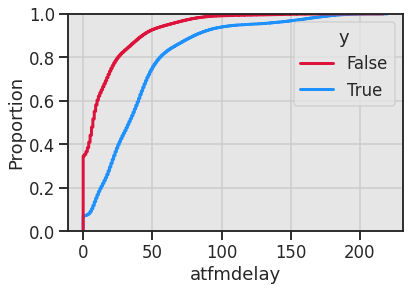

In [14]:
ax = sns.ecdfplot(data=X, x='atfmdelay', hue='y', palette=palette, linewidth=3)

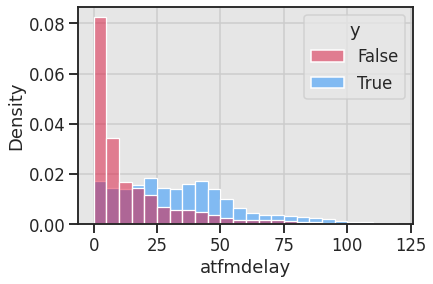

In [15]:
ax = sns.histplot(data=X, x='atfmdelay', hue='y', palette=palette, stat='density', common_norm=False, common_bins=True, binrange=(0, 120), binwidth=5)

The ATFM delay is higher for the positive observations, i.e., dispatchers are more likely to reroute when the delay is high.

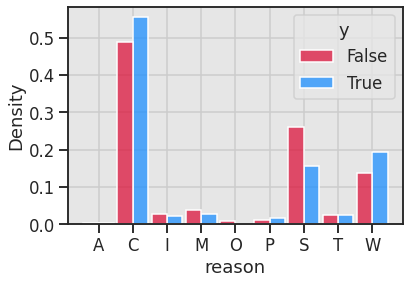

In [16]:
ax = sns.histplot(data=X, x='reason', hue='y', palette=palette, stat = 'density', multiple="dodge", common_norm=False, shrink=0.9)

The relative number of observations with MPR caused by ATC staffing (S) is lower for the positive observations. The relative number of observations with MPR caused by ATC capacity (C) and weather (W), on the other hand, is higher.

*More info:* [ATFM delay codes](https://ansperformance.eu/definition/atfm-delay-codes/)

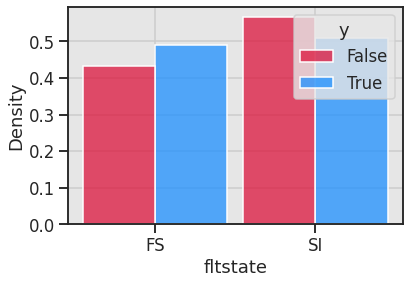

In [17]:
ax = sns.histplot(data=X, x='fltstate', hue='y', palette=palette, stat = 'density', multiple="dodge", common_norm=False, shrink=0.9)

Flight dispathers are more likely to reroute when the flight is in FS state:

* **FS**: ATFM slot allocated.
* **SI**: ATFM slot issued. Slot Allocation message (SAM) sent.

At a fixed time before EOBT, called slot issue time 1 (SIT1), the SAM is sent. Thereafter, the slot cannot be taken by another flight. Moreover, the slot may be improved by the true revision process of CASA.

*More info:* [ATFCM users manual](https://www.eurocontrol.int/sites/default/files/content/documents/nm/network-operations/HANDBOOK/atfcm-users-manual-current.pdf)

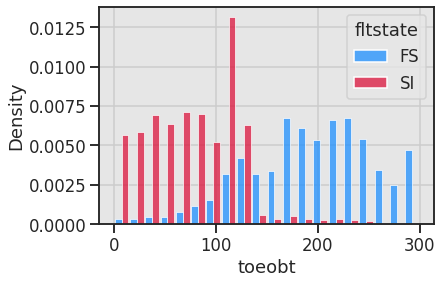

In [18]:
ax = sns.histplot(data=X, x='toeobt', hue='fltstate', palette={'FS':'dodgerblue', 'SI':'crimson'}, stat = 'density', multiple="dodge", common_norm=False, shrink=0.9, binrange=(0, 300), binwidth=15)

The ATFM state of the flight and the time to EOBT are highly correlated. Note that the default SIT1 is 2 hours (120 min) before EOBT.

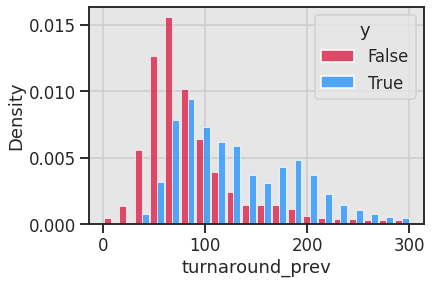

In [19]:
ax = sns.histplot(data=X, x='turnaround_prev', hue='y', palette=palette, stat = 'density', multiple="dodge", common_norm=False, shrink=0.9, binrange=(0, 300), binwidth=15)

Flights with small turn-around time are less likely to reroute.

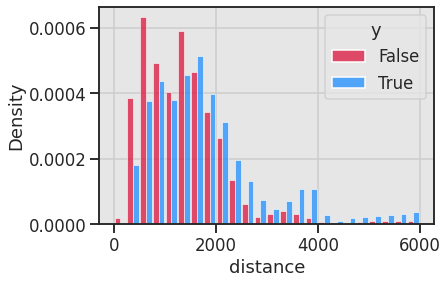

In [20]:
ax = sns.histplot(data=X, x='distance', hue='y', palette=palette, stat = 'density', multiple="dodge", common_norm=False, shrink=0.9, binrange=(0, 6000), binwidth=250)

Shorter flights are less likely to reroute.

<div class="alert alert-block alert-info">
    <code class="docutils literal notranslate"><span class="pre">pandas_profiling</span></code>
    automatically generates a report for exploratory data analysis
</div>

In [21]:
from pandas_profiling import ProfileReport
profile = ProfileReport(X, title="ATFM Rerouting Report",  minimal=True)

In [22]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Train test split

Split dataset into random train and test sets

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
y = X.pop('y')

Each set should contain (approximately) the same percentage of observations of each class as the complete dataset <code class="docutils literal notranslate"><span class="pre">X</span></code>.

<div class="alert alert-block alert-info">
Use the stratify parameter of train_test_split function
</div>

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,  
                                                    stratify=y)

In [26]:
pd.concat([y_train.value_counts(normalize=True).rename('train'), 
           y_test.value_counts(normalize=True).rename('test')], axis=1).round(3)

,train,test
False,0.932,0.932
True,0.068,0.068


In [27]:
for c in category_columns:
    train_categories = X_train.loc[:,c].unique()
    test_categories = X_test.loc[:, c].unique()
    
    missing = set(train_categories).difference(set(test_categories))
    mask = X_test.loc[:, c].isin(missing)
    X_test = X_test.loc[~mask]
    y_test = y_test.loc[~mask]
    
    X_train.loc[:, c] = pd.Categorical(X_train.loc[:, c], categories=train_categories)
    X_test.loc[:, c] = pd.Categorical(X_test.loc[:, c], categories=train_categories)

## Ensemble methods

<div class="alert alert-block alert-info">
The whole section is adapted from scikit-learn documentation
</div>

The goal of ensemble methods is to combine the predictions of several *weak* models in order to improve the performance over a single *strong* model.

Two families:

* In **averaging methods**, the driving principle is to build several models independently and then to average their predictions. The combined model is usually better than any of the single weak models because its variance is reduced.

    *Examples:* Bagging methods, Random Forest, …
    

* By contrast, in **boosting methods**, weak models are built sequentially and one tries to reduce the bias of the combined model. 

    *Examples:* AdaBoost, **Gradient Tree Boosting (GBDT)**, …


<div>
<img src="figures/dt.PNG" width="1000"/>
</div>
<center>Example of a single decision tree (weak learner of GBDT) with with depth 3 and 8 leaves

Why GBDT?

* **No need for transforming features**: A node of a tree partitions the data into 2 sets by comparing a feature (which splits dataset best) to a threshold value. 

<div class="alert alert-block alert-warning">
This is only partially true (Galili and Meilijson, 2016)...
</div>

* **Support for missing values (NaNs)**: During training, the algorithm learns at each split point whether observations with missing values should go to the left or right child, based on the potential gain. When predicting, observations with missing values are assigned to the left or right child consequently.
* **Support for monotonic constraints**: Depending on the problem at hand, you may have prior knowledge indicating that a given feature should in general have a positive (or negative) effect on the target value. 
* **Support for categorical variables**: No need for one-hot encoding. *More info*: [Categorical features support](https://scikit-learn.org/stable/modules/ensemble.html?highlight=lightgbm#categorical-features-support)

Galili, Tal and Meilijson, Isaac, **Splitting matters: how monotone transformation of predictor variables may improve the predictions of decision tree models**. 2016

### Training

In [94]:
from lightgbm import LGBMClassifier, log_evaluation, plot_metric

We are going to train the LGBMClassifier to minimise the negative log-likelihood (same as cross-entropy for binary classification problems)


\begin{equation}
L_{\log}(y, p ( \boldsymbol{x} )) = -(y \log p ( \boldsymbol{x} ) + (1 - y) \log (1 - p ( \boldsymbol{x} ))),
\end{equation}

where

\begin{equation}\label{e:p}
    p ( \boldsymbol{x} ) =\sigma ( f ( \boldsymbol{x} ) ) = \frac{1}{1 + e^{-f ( \boldsymbol{x} )}}
\end{equation}

and $f ( \boldsymbol{x} ) \in \Re$ is the logit (actual output of the model). $\sigma$ is the sigmoid function.

**Monotonic constraints**

<p>A positive monotonic constraint is a constraint of the form:</p>
<p><span class="math notranslate nohighlight">\(x_1 \leq x_1' \implies f(x_1, x_2) \leq f(x_1', x_2)\)</span>,
where <span class="math notranslate nohighlight">\(f\)</span> is the model with two features.</p>
<p>Similarly, a negative monotonic constraint is of the form:</p>
<p><span class="math notranslate nohighlight">\(x_1 \leq x_1' \implies f(x_1, x_2) \geq f(x_1', x_2)\)</span>.</p>
<p>Note that monotonic constraints only constraint the output "all else being
equal". Indeed, the following relation <strong>is not enforced</strong> by a positive
constraint: <span class="math notranslate nohighlight">\(x_1 \leq x_1' \implies f(x_1, x_2) \leq f(x_1', x_2')\)</span>.</p>
<p>You can specify a monotonic constraint on each feature using the
<code class="docutils literal notranslate"><span class="pre">monotone_constraints</span></code> parameter. For each feature, a value of 0 indicates no
constraint, while -1 and 1 indicate a negative and positive constraint,
respectively.</p>

From all the features, the only one for which we are sure is the ATFM delay:


The higher the ATFM delay (all else being equal) $\implies$  the higher the probability of rerouting.

In [29]:
mc = []
for c in X.columns:
    if c == 'atfmdelay':
        mc.append(1)
    else:
        mc.append(0)

**Max bins for categorical features**

In state-of-the-art GBDT implementations, the categories of a categorical feature are sorted according to the variance of the target, for each category. Once the categories are sorted, one can consider continuous partitions, i.e. treat the categories as if they were ordered continuous values.

The cardinality (number of unique values) of each categorical feature should be less than the <code class="docutils literal notranslate"><span class="pre">max_bins</span></code> parameter, and each categorical feature is expected to be encoded in <code class="docutils literal notranslate"><span class="pre">[0, max_bins-1]</span></code> integer values.

Let us define <code class="docutils literal notranslate"><span class="pre">max_bin_by_feature</span></code>  according to the cardinality of each individual feature. We are going to use the default value of lightGBM (255), for all numerical features.

In [30]:
mb = []
for c in X.columns:
    if c in number_columns:
        mb.append(255)
    else:
        mb.append(max(255, X[c].nunique()))

In [58]:
model = LGBMClassifier(objective="binary", 
                       max_bin_by_feature=mb,
                       monotone_constraints=mc)

callbacks = [log_evaluation(10)]

model = model.fit(X_train, y_train, 
          eval_set = [(X_train, y_train)],
          categorical_feature="auto",
          callbacks=callbacks)

[10]	training's binary_logloss: 0.181545
[20]	training's binary_logloss: 0.162872
[30]	training's binary_logloss: 0.154043
[40]	training's binary_logloss: 0.149027
[50]	training's binary_logloss: 0.14574
[60]	training's binary_logloss: 0.143301
[70]	training's binary_logloss: 0.141388
[80]	training's binary_logloss: 0.139885
[90]	training's binary_logloss: 0.138548
[100]	training's binary_logloss: 0.137368


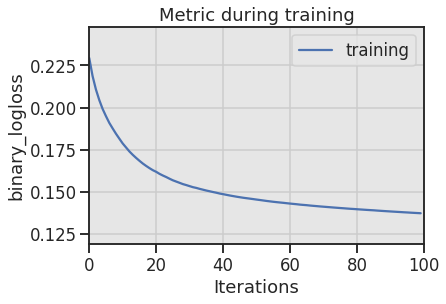

In [59]:
ax = plot_metric(model)

### Performance assessment

In a binary classification task, the terms "positive" and "negative" refer to the model's prediction, while "true" and "false" refer to whether or not that prediction corresponds to the actual observation. 

**Definitions**:

* TP: true positives
* FP: false positives
* TN: true negatives
* FN: false negatives
* P = TP + FN: actual positives
* N = FP + TN: actual negatives

Let us predict with the trained model:

In [61]:
y_hat = pd.Series(model.predict_proba(X_test)[:,1], 
                  index=X_test.index, 
                  name='y_hat')

In [96]:
y_hat.head()

id
860104     0.039078
612420     0.017108
786849     0.015008
1768178    0.034299
1059741    0.001170
Name: y_hat, dtype: float64

We are going to compare the model with a *dummy* classiffier that ignores the input features. 

The <code class="docutils literal notranslate"><span class="pre">predict_proba</span></code> method of such a dummy classifier randomly samples one-hot vectors from a multinomial distribution parametrised by the empirical class prior probabilities. 

In [62]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent").fit(X_train, y_train)
y_dummy = pd.Series(dummy.predict_proba(X_test)[:, 1], 
                    index=X_test.index, 
                    name='y_dummy')

In [97]:
y_dummy.head()

id
860104     0.0
612420     0.0
786849     0.0
1768178    0.0
1059741    0.0
Name: y_dummy, dtype: float64

**Accuracy**

The accuracy is the fraction of correct predictions:

\begin{equation}
{\displaystyle \mathrm {ACC} ={\frac {\mathrm {TP} +\mathrm {TN} }{\mathrm {P} +\mathrm {N} }}={\frac {\mathrm {TP} +\mathrm {TN} }{\mathrm {TP} +\mathrm {TN} +\mathrm {FP} +\mathrm {FN} }}}
\end{equation}

In [63]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_hat > 0.5))
print(accuracy_score(y_test, y_dummy > 0.5))

0.9518864911209114
0.9318391957546245


<div class="alert alert-block alert-warning">
Accuracy is not a good metric for imbalanced classification problems (accuracy paradox)
</div>

**Precision and recall**

Let us define the precision and the recall as:

\begin{equation}
\text{precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
\end{equation}

*what proportion of positive predictions was correct?*

\begin{equation}
{\displaystyle \mathrm {recall} ={\frac {\mathrm {TP} }{\mathrm {P} }}={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FN} }}  }
\end{equation}

*what proportion of actual positives was predicted correctly?*

These quantities are also related to the f1-score, which is defined as the harmonic mean of precision and recall:

\begin{equation}
\text{f1-score} = 2 \frac{\text{recall} \times \text{precision}}{\text{recall} + \text{precision}}.
\end{equation}

The <code class="docutils literal notranslate"><span class="pre">classification_report</span></code> function builds a report summarising the main classification metrics. 

These metrics are provided by each class independently, as well as for the overall model. There are two ways to compute the model's precision, recall and f1-score:

* **macro**: unweighted mean. Does not take into account the imbalance 
* **weighted**: average weighted by support (the number of true observations for each class). Takes into account the imbalance

In [64]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_hat > 0.5))

              precision    recall  f1-score   support

       False       0.96      0.99      0.97    332579
        True       0.78      0.41      0.54     24327

    accuracy                           0.95    356906
   macro avg       0.87      0.70      0.76    356906
weighted avg       0.95      0.95      0.94    356906



In [65]:
print(classification_report(y_test, y_dummy > 0.5))

              precision    recall  f1-score   support

       False       0.93      1.00      0.96    332579
        True       0.00      0.00      0.00     24327

    accuracy                           0.93    356906
   macro avg       0.47      0.50      0.48    356906
weighted avg       0.87      0.93      0.90    356906



In [66]:
from sklearn.metrics import confusion_matrix


def cunfusion_matrix_plot(y_test, y_hat):
    def human_format(num):
        num = float('{:.3g}'.format(num))
        magnitude = 0
        while abs(num) >= 1000:
            magnitude += 1
            num /= 1000.0
        return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
    
    cm = confusion_matrix(y_test, y_hat, labels=[False, True])
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '{}\n{}/{}'.format(human_format(round(p)) + '%', human_format(int(c)), human_format(int(s)))
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '{}\n{}'.format( human_format(round(p)) + '%',  human_format(int(c)))
                
    cm = pd.DataFrame(cm, index=[False, True], columns=[False, True])
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    sns.heatmap(cm, annot=annot, fmt='', cbar=False, cmap='Blues', annot_kws=dict(fontsize=16))

**Confusion matrix**

* Each row corresponding to the true class, and each column to the predicted class. 

* The diagonal elements represent the number of observations for which the predicted class is equal to the true class, 

* while off-diagonal elements are those that are wrongly classified. 

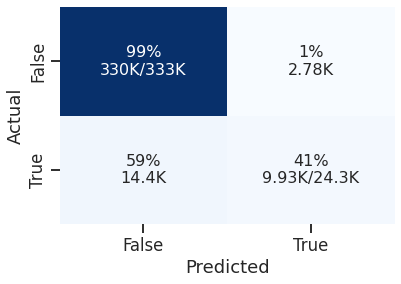

In [67]:
cunfusion_matrix_plot(y_test, y_hat > 0.5)

**Receiver operating characteristic (ROC) curve and area under the curve (AUC)**

The ROC curve illustrates the performance of a binary classifier as its *threshold* is varied. The threshold is applied to the cut-off point in probability between the positive and negative classes, which by default for any classifier would be set at 0.5.


<code class="docutils literal notranslate"><span class="pre">y_hat > 0.5</span></code>

The ROC curve represents:

- **Vertical (Y) axis**: true positive rate (TPR)

\begin{equation}
{\displaystyle \mathrm {TPR} ={\frac {\mathrm {TP} }{\mathrm {P} }}={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FN} }}  }
\end{equation}

*what proportion of actual positives was predicted correctly?*

- **Horizontal (X) axis**: false positive rate (FPR)

\begin{equation}
{\displaystyle \mathrm {FPR} ={\frac {\mathrm {FP} }{\mathrm {N} }}={\frac {\mathrm {FP} }{\mathrm {FP} +\mathrm {TN} }}}
\end{equation}

*what is the proportion of false positives w.r.t the total number of actual negatives?*

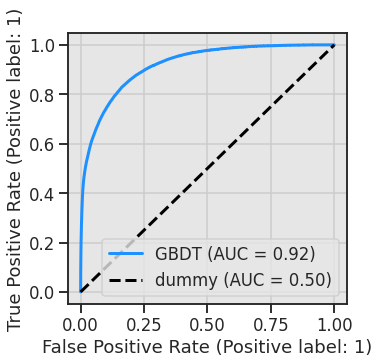

In [68]:
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(5,5))
RocCurveDisplay.from_predictions(y_test, y_hat, name='GBDT', ax=ax, linewidth=3, color='dodgerblue')
ax = RocCurveDisplay.from_predictions(y_test, y_dummy, name='dummy', ax=ax, linewidth=3, linestyle='--', color='black')

<div class="alert alert-block alert-warning">
For imbalanced datasets with few observations of the positive class, the AUC can be misleading. 
</div>


**Precision-Recall (PR) curve and average precision (AP)**

The PR curve represents:

- **Vertical (Y) axis**: precision

\begin{equation}
\text{precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
\end{equation}

*what proportion of positive predictions was correct?*

- **Horizontal (X) axis**: recall

\begin{equation}
{\displaystyle \mathrm {recall} ={\frac {\mathrm {TP} }{\mathrm {P} }}={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FN} }}  }
\end{equation}

*what proportion of actual positives was predicted correctly?*

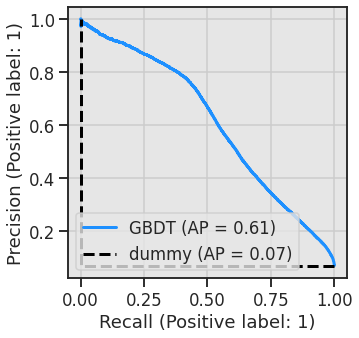

In [69]:
from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(figsize=(5,5))
PrecisionRecallDisplay.from_predictions(y_test, y_hat, name='GBDT', ax=ax, linewidth=3, color='dodgerblue')
ax = PrecisionRecallDisplay.from_predictions(y_test, y_dummy, name='dummy', ax=ax, linewidth=3, linestyle='--', color='black')

<div class="alert alert-block alert-info">
The focus of the PR curve on the positive class makes it a good metric for imbalanced datasets.
</div>

Let us try to train a model that maximises the AP, and that takes into account the imbalance in the data:

In [70]:
model_ap = LGBMClassifier(objective="binary",
                       metric='average_precision',
                       max_bin_by_feature=mb,
                       monotone_constraints=mc,
                       is_unbalance=True)

model_ap = model_ap.fit(X_train, y_train, 
                  eval_set = [(X_train, y_train)],
                  categorical_feature="auto",
                  callbacks=callbacks)

[10]	training's average_precision: 0.51065
[20]	training's average_precision: 0.541658
[30]	training's average_precision: 0.565263
[40]	training's average_precision: 0.582137
[50]	training's average_precision: 0.595146
[60]	training's average_precision: 0.604636
[70]	training's average_precision: 0.611763
[80]	training's average_precision: 0.618332
[90]	training's average_precision: 0.62259
[100]	training's average_precision: 0.627155


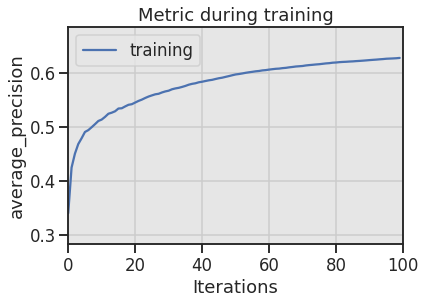

In [71]:
ax = plot_metric(model_ap)

In [72]:
y_hat_ap = pd.Series(model_ap.predict_proba(X_test)[:,1], index=X_test.index, name='y_hat')

In [73]:
print(classification_report(y_test, y_hat_ap > 0.5))

              precision    recall  f1-score   support

       False       0.99      0.84      0.91    332579
        True       0.27      0.83      0.41     24327

    accuracy                           0.84    356906
   macro avg       0.63      0.83      0.66    356906
weighted avg       0.94      0.84      0.87    356906



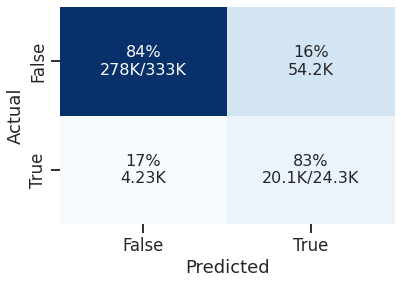

In [74]:
cunfusion_matrix_plot(y_test, y_hat_ap > 0.5)

### Model optimisation

We are going to optimise the hyper-parameters of the model with <code class="docutils literal notranslate"><span class="pre">optuna</span></code>, which uses Bayesian optimisation to find the best combination of values.

Akiba, T. et al. **Optuna: A Next-generation Hyperparameter Optimization Framework**. 2019. In KDD 

In [77]:
from optuna.integration import LightGBMPruningCallback
from lightgbm import early_stopping
from sklearn.metrics import log_loss

def train_and_eval(X_train, X_val, y_train, y_val, trial, param_grid):
    model = LGBMClassifier(objective="binary",
                           max_bin_by_feature=mb,
                           monotone_constraints=mc,
                           n_estimators=1024,
                           **param_grid)

    callbacks = [early_stopping(10, verbose=0), 
                 log_evaluation(period=0)]

    if self.prune:
        callbacks.append(LightGBMPruningCallback(trial, "binary_logloss"))

    model.fit(X_train, y_train, 
              eval_set=[(X_val, y_val)], 
              categorical_feature="auto",
              callbacks=callbacks)

    y_hat = model.predict_proba(X_val)[:, 1]
    loss = log_loss(y_val, y_hat)
    best_iteration = model.best_iteration_
    return loss, best_iteration

In [99]:
def get_parameters(trial):
    return {"num_leaves": trial.suggest_int("num_leaves", 128, 512, log=True),
          "max_depth": trial.suggest_int("max_depth", 8, 32, log=True),
          "min_child_samples": trial.suggest_int("min_child_samples", 16, 256, log=True),
          "subsample": trial.suggest_uniform("subsample", 0.9, 1.0),
          "subsample_freq": trial.suggest_int("subsample_freq", 0, 128, log=False),
          "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.8, 1.0),               
          "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-5, 5.),
          "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-5, 5.)}

In [78]:
from math import ceil
from sklearn.model_selection import StratifiedKFold

class Objective:
    def __init__(self, X, y, prune=False):
        self.X = X
        self.y = y
        self.n_estimators = None
        self.prune = prune
        self.best_score = float("inf")
            
    def __call__(self, trial):
        param_grid = get_parameters(trial)
        spliter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = []
        n_estimators = []
        
        for train_idx, val_idx in spliter.split(self.X, self.y):
            X_train, X_val = self.X.iloc[train_idx], self.X.iloc[val_idx]
            y_train, y_val = self.y.iloc[train_idx], self.y.iloc[val_idx]
            loss, best_iteration = train_and_eval(X_train, X_val, y_train, y_val, 
                                                  trial, param_grid)
            
            scores.append(loss)
            n_estimators.append(best_iteration)
 
        score = np.mean(scores)
        n_estimators = ceil(np.mean(n_estimators))
        if score < self.best_score:
            self.n_estimators = n_estimators
            self.best_score = score
        return score

<div class="alert alert-block alert-warning">
Running the cell below is going to take a lof of time ... 
</div>

In [ ]:
from optuna import create_study

study = create_study(direction="minimize")
objective = Objective(X_train, y_train)
study.optimize(objective, n_trials=200, show_progress_bar=True)
best_params = {**study.best_params, 'n_estimators': objective.n_estimators}

### Model interpretability

**Why is the model predicting this value?**

* Let us assume that each feature $i \in \mathcal{X}$ is a player, and that the output of the model $f ( \boldsymbol{x} )$ is the *payout*. 

* Let us consider the following scenario: all features participate in the game (i.e., contribute to the output of the model), and the features enter the room where the game is played in a random order. 

* The *attribution* of a feature could be calculated as the average change in the payout received by the coalition already in the room when the corresponding player (feature) joins them. This attribution measure is known in the literature as the **Shapley value**. 

* The Shapley value $\phi_i (f, \boldsymbol{x})$ of the feature $i \in \mathcal{X}$ for a given input vector $\boldsymbol{x}$ represents the average marginal contribution of $i$ on the output of the model across all possible coalitions (or combinations) of features.

It can be proven that the Shapley values are the only feature attributions that simultaneously satisfy three important properties when interpreting local predictions: 

* **Local accuracy**: the sum of the attribution of all features should match the output of the model when approximating the original model $f$ for a specific input vector $\boldsymbol{x}$ of an observation:

\begin{equation}\label{e:shap}
    f ( \boldsymbol{x} ) = \mathbb{E} [ f ( \mathcal{T} ) ] + \sum_{i \in \mathcal{X}} \phi_i (f, \boldsymbol{x}),
\end{equation}

where $\mathbb{E} [ f ( \mathcal{T} ) ]$ is the base value, i.e., the mean of the model output over the train set. 
* **Consistency**: if a model changes so that the marginal contribution of a feature increases or remains constant regardless of the other inputs, the attribution of that feature should not decrease.
* **Missingness**: null attribution, i.e. $\phi_i (f, \boldsymbol{x}) = 0$, for features that have no impact on the output of the model.

<div class="alert alert-block alert-warning">
Remember that the actual output of the model is not the probability, but the logit
</div>

This implies that the sum of the base value and the feature contributions approximates the logit, not the probability. Taking into account that:

\begin{equation}
    p ( \boldsymbol{x} ) =\sigma ( f ( \boldsymbol{x} ) ) = \frac{1}{1 + e^{-f ( \boldsymbol{x} )}},
\end{equation}

then,

\begin{equation}
        p ( \boldsymbol{x} ) =\sigma ( f ( \boldsymbol{x} ) ) = \sigma (  \mathbb{E} [ f ( \mathcal{T} ) ] + \sum_{i \in \mathcal{X}} \phi_i (f, \boldsymbol{x}) ) \neq \sigma (  \mathbb{E} [ f ( \mathcal{T} ) ] ) + \sum_{i \in \mathcal{X}} \sigma (   \phi_i (f, \boldsymbol{x}) ) ).
\end{equation}

In [80]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

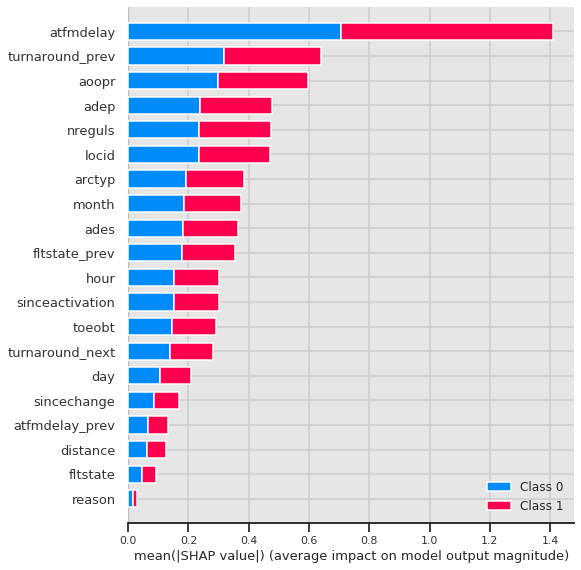

In [82]:
shap.summary_plot(shap_values, X_test, plot_type="bar" )

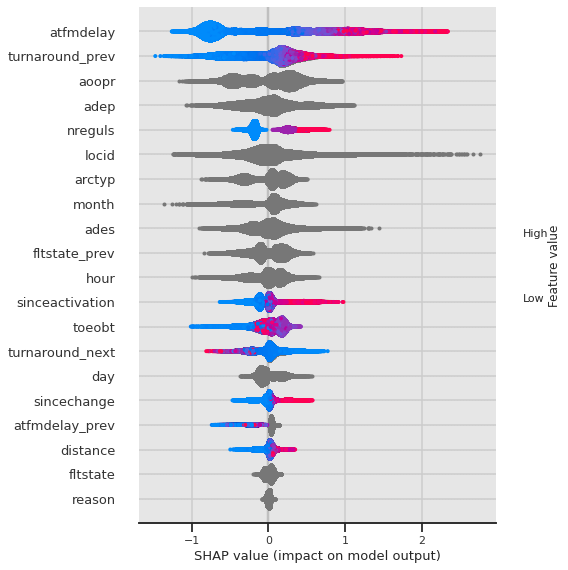

In [83]:
shap.summary_plot(shap_values[1], X_test, show=True)

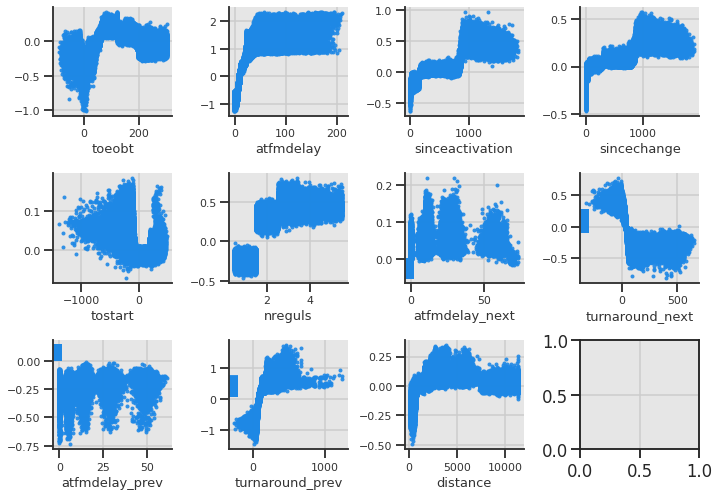

In [84]:
fig, ax = plt.subplots(figsize=(10, 7), nrows=3, ncols=4)
ax = ax.flatten()
for i, c in enumerate(number_columns):
    shap.dependence_plot(c, shap_values=shap_values[1], features=X_test, x_jitter=5, interaction_index=None,alpha=0.9,ax=ax[i],show=False)
    ax[i].set_ylabel('')   
fig.tight_layout()
plt.show()

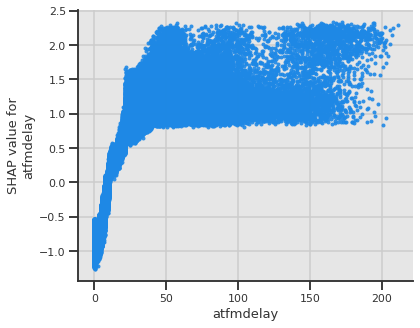

In [85]:
shap.dependence_plot('atfmdelay', shap_values=shap_values[1], features=X_test, x_jitter=5, interaction_index=None,alpha=0.9,show=True)

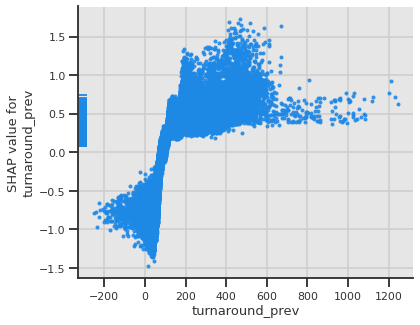

In [86]:
shap.dependence_plot('turnaround_prev', shap_values=shap_values[1], features=X_test,  x_jitter=5, interaction_index=None, alpha=0.9,show=True)

Use the SHAP values as an embedding which we project to 2D for visualization.

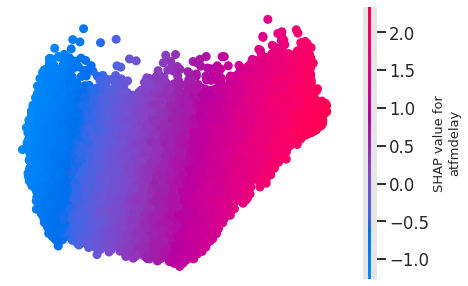

In [87]:
shap.embedding_plot('atfmdelay', shap_values[1], feature_names=X_test.columns, method='pca', alpha=1.0, show=True)

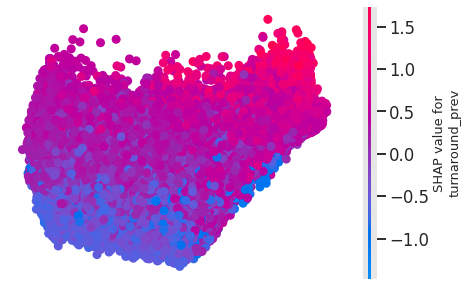

In [88]:
shap.embedding_plot('turnaround_prev', shap_values[1], feature_names=X_test.columns, method='pca', alpha=1.0, show=True)

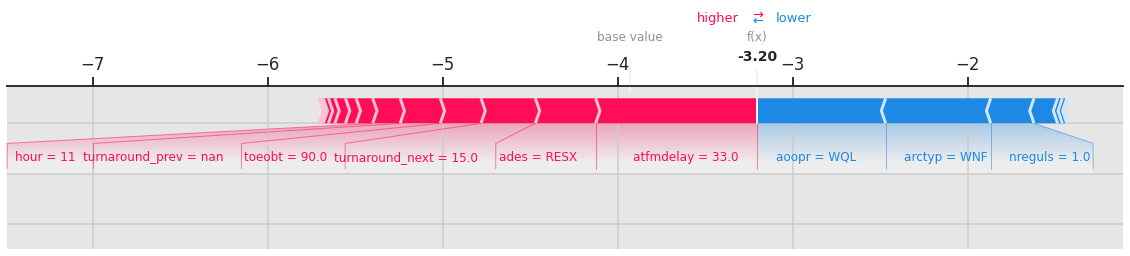

In [89]:
shap.force_plot(explainer.expected_value[1], shap_values=shap_values[1][0], features=X_test.iloc[0], matplotlib=True)

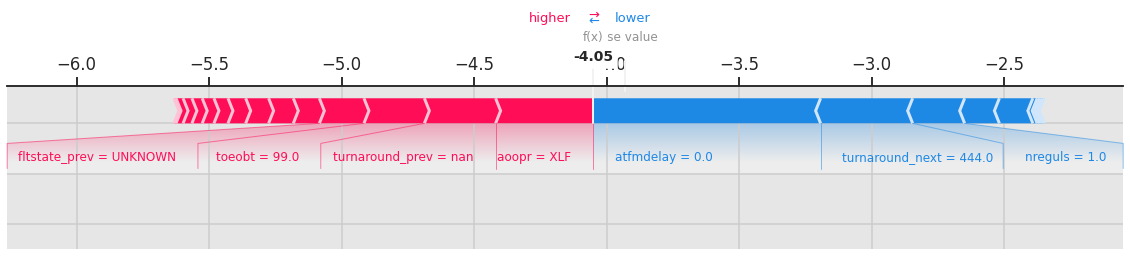

In [90]:
shap.force_plot(explainer.expected_value[1], shap_values=shap_values[1][1], features=X_test.iloc[1], matplotlib=True)

## Neural networks

We are going to train a simple feed-forward neural network to accomplish the same task.
In this case, however, we are going to face some challenges (not applicable when using GBDT): 

* **Missing data**: Some features, like the ATFM delay of the previous flight, are missing.
* **Features with various scales**: Delays are in the range 0-100, while turn-around times could be as high as 1000.
* **Non-gaussian distributions**: ATFM delay is highly skewed, and neural networks prefer gaussian distributions.
* **High-cardinality categorical features**: The departure and destination airports, for instance, have more than 100 categories. 
 - One-hot encoding is not feasible.
 - Ordinal encoding cannot be used because categories are not ordered.

### Transformations

We are going to transform the features as follows:

* Categorical features will be transformed to integers using [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn-preprocessing-ordinalencoder). Then, the neural network will learn the projection of each category in a multi-dimensional space using [embedding layers](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#embedding).

* The delay of the previous and next flights will be set 0 min if missing. For the turn-around times, we are going to use the mean value of the distribution for the sake of simplicity.

* The min-max transformation will be applied to the number of regulations. 
 - [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn-preprocessing-minmaxscaler) rescales the data set such that all feature values are in the range [0, 1].

* Power transformations followed by a standardiation will be applied to the remaining numerical features.
 - [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn-preprocessing-powertransformer) applies a power transformation to make the data more Gaussian-like in order to stabilize variance and minimize skewness. 
 - [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn-preprocessing-standardscaler) removes the mean and scales the data to unit variance. 


In [102]:
delay = ['atfmdelay_next', 'atfmdelay_prev']
turnaround = ['turnaround_next', 'turnaround_prev']
nreguls = ['nreguls']
others = [c for c in number_columns if c not in delay + turnaround + nreguls]

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.2,random_state=42, stratify=y_train)


In [103]:
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

pipeline_delay = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')), 
                                 ('transformer', PowerTransformer(standarize=True))])

pipeline_turnaround = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), 
                                      ('transformer', PowerTransformer(standarize=True))])

transformers = [('category', OrdinalEncoder(), category_columns),
                ('turnaround', pipeline_turnaround, turnaround), 
                ('delay', pipeline_delay, delay),
                ('others', PowerTransformer(standarize=True), others),
                ('nreguls', MinMaxScaler(), nreguls)]

ct = ColumnTransformer(transformers, verbose=False, n_jobs=-1)
ct = ct.fit(X_train)

### Training

In [105]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FeedForwardNN(nn.Module):
    def __init__(self, 
                 embedding_sizes, 
                 number_size,  
                 hidden_sizes = [256, 128, 64],
                 max_embedding_size = 64
                ):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(int(n), min(max_embedding_size, int(n) // 2)) for n in embedding_sizes])
        embedding_size = sum(e.embedding_dim for e in self.embeddings)
        input_size = number_size + embedding_size
        layers = []
        for h in hidden_sizes:
            layers.append(nn.Sequential(nn.Linear(input_size, h), nn.ReLU()))
            input_size = h
        layers.append(nn.Sequential(nn.Linear(h, 1), nn.Sigmoid()))     
        self.linear = nn.Sequential(*layers)

    def forward(self, X):
        category = X[..., :len(self.embeddings)].long()
        number = X[..., len(self.embeddings):]
        embedding = torch.cat([e(category[..., i]) for i, e in enumerate(self.embeddings)], dim=-1)
        x = torch.cat([number, embedding], dim=-1).float()
        return self.linear(x)

In [106]:
def train_model(device, model, epochs, optimiser, dataloader_train, dataloader_val, patience=5):
    base_loss = float("inf")
    counter = 0
    model.train()
    best_model = model
    for epoch in range(1, epochs+1):  
        cum_loss = 0.
        for i, (X, y) in enumerate(dataloader_train, 1):
            X = X.to(device)
            y = y.to(device).double()
            optimiser.zero_grad()
            y_hat = model(X).double()
            loss = F.binary_cross_entropy(y_hat, y)
            loss.backward()
            optimiser.step()
            cum_loss += loss.item()
            if i % 1000 == 0:
                # early stopping
                val_loss = validate_model(model, device, dataloader_val)
                if val_loss > base_loss:
                    counter += 1
                    if counter >= patience:
                        return best_model
                else:
                    base_loss = val_loss
                    best_model = model
                    counter = 0
                    
                print('[{}/{}, {}/{}] train: {:.3f} val: {:.3f}'.format(epoch, epochs, i, len(dataloader_train), cum_loss / 1000, val_loss))
                cum_loss = 0.
                model.train()
    return best_model

In [34]:
def validate_model(model, device, dataloader_val):
    model.eval()
    losses = []
    with torch.no_grad():
        for X, y in dataloader_val:
            X = X.to(device)
            y = y.to(device).double()
            y_hat = model(X).double()
            losses.append(F.binary_cross_entropy(y_hat, y, reduce='none'))
    return torch.stack(losses).mean().item()

In [36]:
embedding_sizes = X[category_columns].describe().loc['unique'].values.tolist()
number_size = len(number_columns)

model = FeedForwardNN(embedding_sizes, number_size)

In [38]:
model

FeedForwardNN(
  (embeddings): ModuleList(
    (0): Embedding(18, 9)
    (1): Embedding(7, 3)
    (2): Embedding(12, 6)
    (3): Embedding(115, 57)
    (4): Embedding(140, 64)
    (5): Embedding(30, 15)
    (6): Embedding(67, 33)
    (7): Embedding(2, 1)
    (8): Embedding(352, 64)
    (9): Embedding(9, 4)
    (10): Embedding(7, 3)
    (11): Embedding(4, 2)
  )
  (linear): Sequential(
    (0): Sequential(
      (0): Linear(in_features=272, out_features=256, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
)

In [39]:
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10
batch_size = 64
lr = 0.001
model = model.to(device)
optimiser = Adam(model.parameters(), lr=lr)

PyTorch provides two data primitives: <code class="docutils literal notranslate"><span class="pre">DataLoader</span></code> and <code class="docutils literal notranslate"><span class="pre">Dataset</span></code>:

* <code class="docutils literal notranslate"><span class="pre">Dataset</span></code> stores the samples and their corresponding labels,
* and <code class="docutils literal notranslate"><span class="pre">DataLoader</span></code> wraps an iterable around
the <code class="docutils literal notranslate"><span class="pre">Dataset</span></code> to enable easy access to the samples.

In [32]:
from torch.utils.data import TensorDataset, DataLoader

dataset_train = TensorDataset(torch.from_numpy(ct.transform(X_train)), 
                              torch.from_numpy(y_train.values).view(-1, 1))
dataset_val = TensorDataset(torch.from_numpy(ct.transform(X_val)), 
                            torch.from_numpy(y_val.values).view(-1, 1))
dataset_test = TensorDataset(torch.from_numpy(ct.transform(X_test)), 
                             torch.from_numpy(y_test.values).view(-1, 1))

In [40]:
dataloader_train = DataLoader(dataset_train, batch_size, shuffle=True, num_workers=1)
dataloader_val = DataLoader(dataset_val, 1024, shuffle=False, num_workers=1)
dataloader_test = DataLoader(dataset_test, 1024, shuffle=False, num_workers=1)

In [41]:
model = train_model(device, model, epochs, optimiser, dataloader_train, dataloader_val, patience=5)

[1/10, 1000/17846] train: 0.180 val: 0.164
[1/10, 2000/17846] train: 0.165 val: 0.163
[1/10, 3000/17846] train: 0.158 val: 0.158
[1/10, 4000/17846] train: 0.160 val: 0.158
[1/10, 5000/17846] train: 0.159 val: 0.156
[1/10, 6000/17846] train: 0.159 val: 0.157
[1/10, 7000/17846] train: 0.158 val: 0.154
[1/10, 8000/17846] train: 0.157 val: 0.154
[1/10, 9000/17846] train: 0.157 val: 0.155
[1/10, 10000/17846] train: 0.153 val: 0.153
[1/10, 11000/17846] train: 0.152 val: 0.152
[1/10, 12000/17846] train: 0.155 val: 0.152
[1/10, 13000/17846] train: 0.150 val: 0.151
[1/10, 14000/17846] train: 0.153 val: 0.153
[1/10, 15000/17846] train: 0.156 val: 0.153
[1/10, 16000/17846] train: 0.154 val: 0.157
[1/10, 17000/17846] train: 0.150 val: 0.151
[2/10, 1000/17846] train: 0.153 val: 0.151
[2/10, 2000/17846] train: 0.147 val: 0.150
[2/10, 3000/17846] train: 0.150 val: 0.153
[2/10, 4000/17846] train: 0.149 val: 0.150
[2/10, 5000/17846] train: 0.146 val: 0.150
[2/10, 6000/17846] train: 0.149 val: 0.150
[2/

Is the neural network better than the GBDT?

In [43]:
model = model.eval()
y_nn = [model(X.to(device)).detach().cpu().numpy() for X,_ in dataloader_test]
y_nn = pd.Series(np.concatenate(y_nn, axis=0)[:, 0], index=X_test.index, name='y_nn')
print(classification_report(y_test, y_nn > 0.5))

              precision    recall  f1-score   support

       False       0.96      0.99      0.97    332579
        True       0.74      0.38      0.50     24327

    accuracy                           0.95    356906
   macro avg       0.85      0.69      0.74    356906
weighted avg       0.94      0.95      0.94    356906



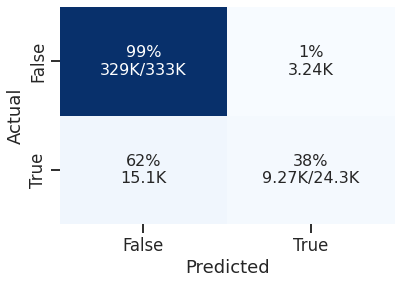

In [44]:
cunfusion_matrix_plot(y_test, y_nn > 0.5)

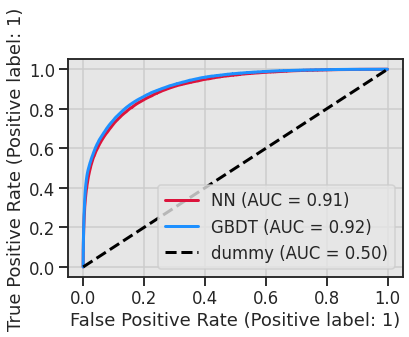

In [47]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, y_nn, name='NN', ax=ax, linewidth=3, color='crimson')
RocCurveDisplay.from_predictions(y_test, y_hat, name='GBDT', ax=ax, linewidth=3, color='dodgerblue')
ax = RocCurveDisplay.from_predictions(y_test, y_dummy, name='dummy', ax=ax, linewidth=3, linestyle='--', color='black')

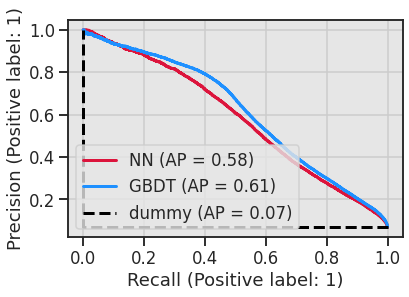

In [49]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_test, y_nn, name='NN', ax=ax, linewidth=3, color='crimson')
PrecisionRecallDisplay.from_predictions(y_test, y_hat, name='GBDT', ax=ax, linewidth=3, color='dodgerblue')
ax = PrecisionRecallDisplay.from_predictions(y_test, y_dummy, name='dummy', ax=ax, linewidth=3, linestyle='--', color='black')

How could we deal with the data imbalance problem? 

Using the [WeightedRandomSampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler) in the train dataloader, giving more weight to *rare* (positive) samples during the sampling process.

In [56]:
from torch.utils.data import WeightedRandomSampler

class_weights = 1 - y_train.value_counts(normalize=True)
sample_weight = y_train.map(class_weights)
sampler = WeightedRandomSampler(weights=sample_weight.values.tolist(), 
                                num_samples=len(y_train))

dataloader_train = DataLoader(dataset_train, batch_size, sampler=sampler, num_workers=1)

In [60]:
model = FeedForwardNN(embedding_sizes, number_size)
model = model.to(device)
optimiser = Adam(model.parameters(), lr=lr)
model = train_model(device, model, epochs, optimiser, dataloader_train, dataloader_val, patience=5)

[1/10, 1000/17846] train: 0.427 val: 0.390
[1/10, 2000/17846] train: 0.391 val: 0.413
[1/10, 3000/17846] train: 0.386 val: 0.357
[1/10, 4000/17846] train: 0.382 val: 0.400
[1/10, 5000/17846] train: 0.377 val: 0.392
[1/10, 6000/17846] train: 0.368 val: 0.333
[1/10, 7000/17846] train: 0.365 val: 0.383
[1/10, 8000/17846] train: 0.362 val: 0.413
[1/10, 9000/17846] train: 0.358 val: 0.374
[1/10, 10000/17846] train: 0.356 val: 0.382


In [62]:
model = model.eval()
y_nn = [model(X.to(device)).detach().cpu().numpy() for X,_ in dataloader_test]
y_nn = pd.Series(np.concatenate(y_nn, axis=0)[:, 0], index=X_test.index, name='y_nn')

print(classification_report(y_test, y_nn > 0.5))

              precision    recall  f1-score   support

       False       0.98      0.82      0.89    332579
        True       0.25      0.83      0.38     24327

    accuracy                           0.82    356906
   macro avg       0.62      0.82      0.64    356906
weighted avg       0.93      0.82      0.86    356906



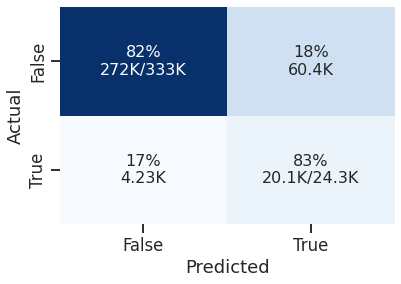

In [63]:
cunfusion_matrix_plot(y_test, y_nn > 0.5)

### Embedding visualisation

See [embedding projector tool](https://projector.tensorflow.org/) for more info

In [68]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_embedding(embeddings, name, ax=None):
    pca = PCA(2)
    tsne = TSNE(2)
    pca_proj = pca.fit_transform(embeddings)
    tsne_proj = tsne.fit_transform(embeddings)
    
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,3), squeeze=True)
    
    ax[0].scatter(pca_proj[:, 0], pca_proj[:, 1])
    ax[0].set_title(name + ' PCA')
    ax[1].scatter(tsne_proj[:, 0], tsne_proj[:, 1])
    ax[1].set_title(name + ' TSNE')
    ax[0].set_ylabel('Component #2')

n_components=2 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'


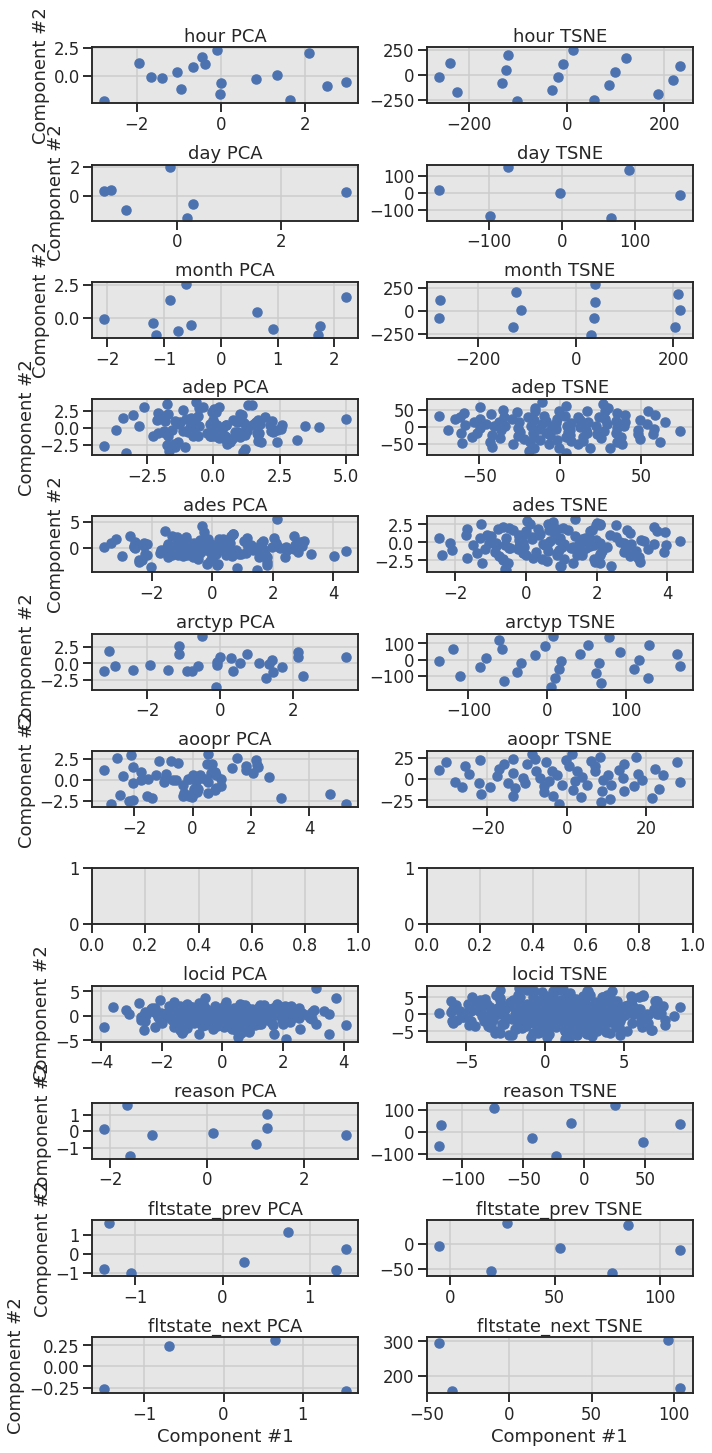

In [72]:
fig, ax = plt.subplots(figsize=(10, 20), nrows=len(category_columns), ncols=2, squeeze=False)

for i, (c, e) in enumerate(zip(category_columns, model.embeddings)):
    e = e.weight.detach().cpu().numpy()
    try:
        plot_embedding(e, c, ax=ax[i])
    except Exception as e:
        print(e) 
    
    if i == len(category_columns) - 1:
        ax[i, 0].set_xlabel('Component #1')
        ax[i, 1].set_xlabel('Component #1')
        
fig.tight_layout()
plt.show()

<div class="alert alert-block alert-success">
<b>Homework</b>: Optimise hyper-parameters of the neural network
</div>
<div class="alert alert-block alert-info">
Use pytorch-lightning to implement the process described above in few lines of code
</div>
<div class="alert alert-block alert-info">
Use captum to interpret the predictions of the neural network 
</div>

## Topics for research

* Supervised learning
    - Prediction of demand
    - Prediction of capacity 
* Unsupervised learning
    - Confidential data labelling 
    - Actual capacity inference
* Reinforcement learning
    - Airline policy under ATFM measures
    - Optimal (network-wide and cooperative) ATFM measures


# Thank you for your attention!